# CSE 4303 Computer Graphics

## Honors Project

### Swangya Saurav

## Assignment 5

**Task : **  Practice in curved surfaces

********
#### Importing important libraries

#### Import File Details
* **ipwidgets** - Used for creating dtnamic interaction widgets
* **IPython.display** - Used to display widgets
* **matplotlib** - Used to plot the graphic object
* **numpy** - Used for calculations

In [1]:
import ipywidgets as widgets
from IPython.display import display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

from matplotlib.patches import Rectangle
import numpy as np


#### Function: getFiledata
This function is used to get the file name the user selected and then extract the data from that file into a python list.

In [2]:
def getFiledata(filename):
    a =[]
    with open(filename) as textFile:
        a = [line.split() for line in textFile]
    list = [x for x in a if x != []]
    lines = list
    return list

w = interact_manual(getFiledata, filename = widgets.RadioButtons(options=["pyramid.txt", "cow.txt", "teapot.txt"]))

#### Function: extractCamData
This function will extract data of all the cameras in the camera file and put them into list 

In [3]:
def extractCamData():
    cam = getFiledata("cameras_04.txt")
    camData = []
    temp = []
    flg = 0
    for element in cam:
        if element[0] == 'c' and flg == 1:
            camData.append(temp)
            temp = []
        else:
            temp.append(element)
            flg = 1
    camData.append(temp)
    return camData            

#### Function: create_vertex_list
This function extracts the list of points in the graphic object.
it is to be noted that the vertex data in the data set is marked by a 'v' at the start of each line and this function takes advantage of that information

In [4]:
def create_vertex_list(data):
    vertex_list = []
    for element in data:
        if element[0] == 'v':
            vertex_list.append([float(element[1]), float(element[2]), float(element[3]), 1])
    return vertex_list

#### Function: create_edge_list
This function extracts the list of connection between points in the graphic object.
it is to be noted that the relation data in the data set is marked by a 'f' at the start of each line and this function takes advantage of that information

In [5]:
def create_edge_list(data):
    edge_list = []
    for element in data:
        if element[0] == 'f':
            edge_list.append([float(element[1]), float(element[2]), float(element[3])])
    return edge_list

## Bezier Surfaces:
A Bezier curve in two dimensions is defined by four "control points". From these four points, all the points on the parametric curve can be interpolated. Similarly, three dimensional Bezier surface patches can be defined by a grid of sixteen control points. These can be though of as four rows, with each row being a 2D Bezier curve. Sixteen control points define an entire curved surface. Clearly one of the advantages of Bezier patches is that they allow a much more concise representation than vertex, polygon lists. Other virtues of parametric surfaces are that they provide exact analytical descriptions of surfaces, and permit easy deformations of those surfaces

### Bezier Formulation
** Bezier Curves ** <br/>
My method calculates points on the curve through weighted interpolation of the four control points.
<img src="./images/BezierCurve.png" width="400"/>

What contribution each control point makes to the curve depends on a single parameter, u, with 0 <= u <= 1. As u varies along the curve each control point's contribution varies as a function of u. In fact, each control point has a function which controls its influence; these are known as the Bernstein basis functions. If we look at the graph below, we see that the function for the first control point has a value of 1 when u = 0, and decays to 0 as u approaches 1. This means that the first control point contributes 100% to the curve when the curve is very close to it, and that when the curve is far away, it hardly contributes anything. The Bernstein basis functions cause Bezier curves to pass through the starting and ending control points.
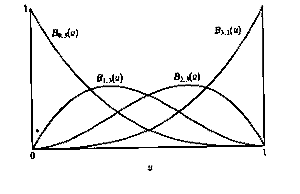

For a given value of u, a point Q on a Bezier curve is defined as the sum of the four control points, weighted by the value of the basis functions for that value of u:

<center>$Q(u) = \Sigma p_i B_i(u)$</center>
And the Bernstein basis functions are defined as follows:
<center>$B_0(u) =  (1-u)^3$</center>
<center>$B_1(u) =  3u(1-u)^2$</center>
<center>$B_2(u) =  3u^2(1-u)$</center>
<center>$B_3(u) =  u^3$</center>
<br/>
** Cubic Bezier Surfaces **<br/>
Turning now to 3D Bezier surface patches; these are defined by grid of 16 control points (4 rows, 4 columns). Each row of four control points can be thought of as a separate 2D Bezier curve. If we first compute a point on each of the curves for a given value of u , say 0.2, we can then treat these new points as the control points for 2D Bezier curves running down the columns. In this way points are interpolated bilinearly to generate the surface patch. The Bezier curves which form the boundaries of the patch will also be points in the 3D surface. Thus, for a given value of (u,v), a point Q on a Cubic Bezier surface can be defined as the weighted sum of all of the control points in the patch:
<center>$Q(u) = \Sigma \Sigma p_{ij} B_i(u)B_j(v)$</center>

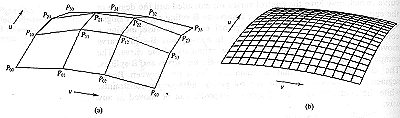
<br/>
** Generating Polygon Mesh From Control Points: **<br/>
Calculate evenly spaced points on the surface, and use these points to define a grid of vertices and polygons. Using this method, we would take the following steps to calculate a point on the surface:
1. Consider each row of control points as defining 4 separate Bezier curves $Q_0(u), ...,Q_3(u)$
2. For some value of u, say 0.1, for each Bezier curve, calculate  $Q_i(u)$
3. Use these derived points as the control points for new Bezier curves running in the v direction
<br/>
<br/>
Source: ** Rendering Cubic Bezier Patches ** by Chris Bentley [Link](https://web.cs.wpi.edu/~matt/courses/cs563/talks/surface/bez_surf.html)

#### Function: create_bezierList
This function extracts all bezier points in the given file

In [6]:
def create_bezierList(data):
    bList = []
    for element in data:
        if element[0] == 'b':
            bList.append([float(element[1]), float(element[2]), float(element[3])])
    return bList

#### Function: get_viewport
This function extracts the viewport dimensions
it is to be noted that this dimension in the data set is marked by a 's' at the start of each line and this function takes advantage of that information

In [7]:
def get_viewport(data):
    view_dimension = []
    for element in data:
        if element[0] == 's':
            dimension = element
            break
    view_dimension = [float(dimension[1]),float(dimension[2]), float(dimension[3]), float(dimension[4])]
    return view_dimension

In [8]:
def get_bezier_points(lim, bezier_list, original_vertex_list, original_edge_list):
    total = len(bezier_list)
    bezier_P_list = []
    temp = []
    bFaces = original_edge_list
    vList = original_vertex_list
    for i in range(0, total, 4):
        temp = []
        for j in range(i, (i+4)):
            temp.append(bezier_list[j])
        bezier_P_list.append(temp)

    P_length = len(bezier_P_list)
    
    temp = []
    bezPoint = []
    bezFaces = []
    for i in range(0, P_length, 4):
        bezPoint = []
        bezFaces = []
        end = i + 4
        temp = create_bezier_surface(bezier_P_list[i:end], lim)
        bezPoint = bezPoint + temp
        bezFaces = bezFaces + bezEdge(vList, lim)
        vList = vList + bezPoint
        bFaces = bFaces + bezFaces
    return [vList, bFaces]

In [9]:
def create_bezier_surface(bezier_P_list, lim):
    lim = lim+1
    uinc = 1.0/float(lim-1)
    u = 0
    B = []
    B0 = []
    B1 = []
    B2 = []
    B3 = []


    for i in range(0, lim):
        u_sqr = np.square(u)
        tmp = 1.0 - u
        tmp_sqr = np.square(tmp)
        B0.append(tmp * tmp_sqr)
        B1.append(3 * u * tmp_sqr)
        B2.append(3 * u_sqr * tmp)
        B3.append(u * u_sqr)
        u = u+uinc
    B.append(B0)
    B.append(B1)
    B.append(B2)
    B.append(B3)



    point = []
    for i in range(0, lim):
        a1 = Curve(i, [bezier_P_list[0][0], bezier_P_list[1][0], bezier_P_list[2][0], bezier_P_list[3][0]], B)
        a2 = Curve(i, [bezier_P_list[0][1], bezier_P_list[1][1], bezier_P_list[2][1], bezier_P_list[3][1]], B)
        a3 = Curve(i, [bezier_P_list[0][2], bezier_P_list[1][2], bezier_P_list[2][2], bezier_P_list[3][2]], B)
        a4 = Curve(i, [bezier_P_list[0][3], bezier_P_list[1][3], bezier_P_list[2][3], bezier_P_list[3][3]], B)
        for j in range(0, lim):
            temp = []
            temp = Curve(j, [a1, a2, a3, a4], B)
            temp.append(1)
            point.append(temp)
    return(point)
    

def Curve(t, c, B):
    c = np.array(c)
    a = []
    curve = np.multiply(c[0], B[0][t]) + np.multiply(c[1], B[1][t]) + np.multiply(c[2], B[2][t]) + np.multiply(c[3], B[3][t])
    temp = np .add(np.multiply(c[0], B[0][t]), np.add(np.multiply(c[1], B[1][t]), np.add(np.multiply(c[2], B[2][t]), np.multiply(c[3], B[3][t]))))
    return curve.tolist()

def bezExample(p1, p2, p3, p4, resolution):
    lim = resolution
    
    p1 = p1.split()
    p2 = p2.split()
    p3 = p3.split()
    p4 = p4.split()
    
    p1 = [float(i) for i in p1]
    p2 = [float(i) for i in p2]
    p3 = [float(i) for i in p3]
    p4 = [float(i) for i in p4]
    
    
    uinc = 1.0/float(lim-1)
    u = 0
    B = []
    B0 = []
    B1 = []
    B2 = []
    B3 = []

    for i in range(0, lim):
        u_sqr = np.square(u)
        tmp = 1.0 - u
        tmp_sqr = np.square(tmp)
        B0.append(tmp * tmp_sqr)
        B1.append(3 * u * tmp_sqr)
        B2.append(3 * u_sqr * tmp)
        B3.append(u * u_sqr)
        u = u+uinc
    B.append(B0)
    B.append(B1)
    B.append(B2)
    B.append(B3)
    
    point = []
    for j in range(0, lim):
            temp = []
            temp = Curve(j, [p1, p2, p3, p4], B)
            point.append(temp)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_ylim([-1, 1])
    ax1.set_xlim([-1, 1])
    
    xpoint = []
    ypoint = []
    for element in point:
        xpoint.append(element[0])
        ypoint.append(element[1])
    plt.plot(xpoint, ypoint, linewidth=1)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

w = interact(bezExample, p1 = '-0.9 0.1 0.1', p2 = '-0.9 0.75 0', p3 ="0.9 0.75 0", p4 = "0.9 0.1 0.9", resolution = widgets.IntSlider(value = 4.0, max=50, min = 2))

In [10]:
def bezEdge(vertList, lim):
    faces = []
    lim = lim + 1
    n = len(vertList)
    for i in range((lim*lim)-1):
        n1 = i+1
        if n1%lim != 0 and n1+lim < (lim*lim):
            temp = [(i+n+1), (n1 + n+1), (n1+lim+n+1)]
            faces.append(temp)
    return faces

#### Function: get_window
This function extracts the windows dimensions
it is to be noted that this dimension in the data set is marked by a 'w' at the start of each line and this function takes advantage of that information

In [11]:
def get_window(data):
    for element in data:
        if element[0] == 'w':
            dimension = element
            break
    window_dimension = [float(dimension[1]),float(dimension[3]), float(dimension[2]), float(dimension[4])]
    return window_dimension

## To Translate points
### 3D Translation
A point $P = \left[ {\matrix{ x  \cr y \cr z \cr  1\cr} } \right]$ in 3D space can be translated (moved) by $d_x$ in the $x$ direction, $d_y$ in the $y$ direction, $d_z$ in the $z$ direction. The coordinates of the point after the translation will be: $P = \left[ {\matrix{ x+d_x  \cr y+d_y  \cr z+d_z \cr} } \right]$.

The translation operation can be shown in matrix form as: $$\left[ {\matrix{
   1 & 0 & 0 & d_x  \cr 
   0 & 1 & 0 & d_y  \cr
   0 & 0 & 1 & d_z  \cr
   0 & 0 & 0 & 1    \cr
 } } \right]  \left[ {\matrix{
   {x}  \cr 
   {y}  \cr
   {z}  \cr
   {1}  \cr
 } } \right] = \left[ {\matrix{
   {x+d_x}  \cr 
   {y+d_y}  \cr
   {z+d_z}  \cr
       {1}  \cr
 } } \right]$$
 

In [12]:
def translation(dx, dy, dz, points):
    translationMat = np.array([[1, 0, 0, dx], [0, 1, 0, dy], [0, 0, 1, dz], [0, 0, 0, 1]])
    
    pointMat = np.array(points)
    pointMat = np.transpose(pointMat)
    
    pointMat = translationMat.dot(pointMat)
    pointMat = np.transpose(pointMat)
    
    return [pointMat.tolist(), translationMat]
    #return pointMat.tolist()
    
def translationExample(x, y, z):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_ylim([-10, 10])
    ax1.set_xlim([-10, 10])
    
    points = [[0, 0, 0, 1], [5, 1, 0, 1], [3, 4, 0, 1]]
    temp = translation(x, y, z, points)
    points = temp[0]
    #points = translation(x, y, z, points)
    
    print("Translation Matrix: ")
    mat = temp[1]
    print(mat)
    
    xpoint = []
    ypoint = []
    for element in points:
        xpoint.append(element[0])
        ypoint.append(element[1])
    xpoint.append(points[0][0])
    ypoint.append(points[0][1])
    plt.plot(xpoint, ypoint, linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

w = interact(translationExample, x = widgets.FloatSlider(value = 0.0, max=10.0, min = -10.0), y = widgets.FloatSlider(value = 0.0, max=10.0, min = -10.0), z = 0.0)

## To Scale points
### 3D Scaling

A point $P = \left[ {\matrix{ x  \cr y  \cr  z \cr} } \right]$ in 3D space can be scaled by $s_x$ in the $x$ direction, $s_y$ in the $y$ direction, and $s_z$ in the $z$ direction. The coordinates of the point after the scaling will be: $P = \left[ {\matrix{s_x x  \cr s_y  y  \cr s_z  z  \cr } } \right]$.

The Scaling operation can be shown in matrix form as: $$\left[ {\matrix{
   s_x & 0 & 0 & 0  \cr 
   0 & s_y & 0 & 0  \cr
   0 & 0 & s_z & 0  \cr
   0 & 0 & 0 & 1    \cr
 } } \right]  \left[ {\matrix{
   {x}  \cr 
   {y}  \cr
   {z}  \cr
   {1}  \cr
 } } \right] = \left[ {\matrix{
   {s_x z}  \cr 
   {s_y y}  \cr
   {s_z z}  \cr
       {1}  \cr
 } } \right]$$

In [13]:
scaleMat = []
def scale(sx, sy, sz, points, scalePoint):
    global scaleMat
    scaleMat = np.array([[sx, 0, 0, 0], [0, sy, 0, 0], [0, 0, sz, 0], [0, 0, 0, 1]])
    temp = translation(-float(scalePoint[0]), -float(scalePoint[1]), -float(scalePoint[2]), points)
    points = temp[0]
    pointMat = np.array(points)
    pointMat = np.transpose(pointMat)
    
    pointMat = scaleMat.dot(pointMat)
    pointMat = np.transpose(pointMat)
    
    temp = translation(float(scalePoint[0]), float(scalePoint[1]), float(scalePoint[2]), pointMat.tolist())
    points = temp[0]
    return points
                         
def scaleExample(x, y, z, scalePoint):
    global scaleMat
    scalePoint = scalePoint.split()
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_ylim([-10, 10])
    ax1.set_xlim([-10, 10])
    
    points = [[0, 0, 0, 1], [5, 1, 0, 1], [3, 4, 0, 1]]
    points = scale(x, y, z, points, scalePoint)
    print("Scale Matrix: ")
    print(scaleMat)
    xpoint = []
    ypoint = []
    for element in points:
        xpoint.append(element[0])
        ypoint.append(element[1])
    xpoint.append(points[0][0])
    ypoint.append(points[0][1])
    plt.plot(xpoint, ypoint, linewidth=1)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

w = interact(scaleExample, x = widgets.FloatSlider(value = 1.0, max=2), y = widgets.FloatSlider(value = 1.0, max=2.0), z = 1.0, scalePoint = "0 0 0")

## To Rotate points
### 3D Rotation
A point $P = \left[ {\matrix{ x  \cr y  \cr} } \right]$ in 2D space can be rotated around the origin by $\alpha$ degrees. 

Assuming that the positive rotation is counter-clockwise, The coordinates of the point after the rotation will be:
$\left[ {\matrix{
   {\cos (\alpha )x - \sin (\alpha )y}  \cr 
   {\sin (\alpha ) + \cos (\alpha )y}  \cr 
 } } \right]$
 
The rotation operation can be shown in matrix form as: 
$\left[ {\matrix{
   {\cos (\alpha )} & { - \sin (\alpha )}  \cr 
   {\sin (\alpha )} & {\cos (\alpha )}  \cr 
 } } \right]\left[ {\matrix{
   x  \cr 
   y  \cr 
 } } \right] = \left[ {\matrix{
   {\cos (\alpha )x - \sin (\alpha )y}  \cr 
   {\sin (\alpha ) + \cos (\alpha )y}  \cr 
 } } \right]$

The matrix $R = \left[ {\matrix{
   {\cos (\alpha )} & { - \sin (\alpha )}  \cr 
   {\sin (\alpha )} & {\cos (\alpha )}  \cr 
 } } \right]$
 is the rotation matrix.
 
 In 3D space rotation can be done using following matrix
 $$\ {R_x} = \left[ {\matrix{
   1 & 0 & 0 & 0  \cr 
   0 & {\cos (\alpha )} & { - \sin (\alpha )} & 0  \cr 
   0 & {\sin (\alpha )} & {\cos (\alpha )} & 0  \cr 
   0 & 0 & 0 & 1  \cr 
 } } \right]$$
 
 $$\ {R_y} = \left[ {\matrix{
    {\cos (\alpha )} & 0 & { - \sin (\alpha )} & 0  \cr 
   0 & 1 & 0 & 0  \cr 
   {\sin (\alpha )} & 0 & {\cos (\alpha )} & 0  \cr 
   0 & 0 & 0 & 1  \cr 
 } } \right]$$
 
 $$\ {R_z} = \left[ {\matrix{
   {\cos (\alpha )} & { - \sin (\alpha )} & 0 & 0  \cr 
   {\sin (\alpha )} & {\cos (\alpha )} & 0 & 0  \cr 
   0 & 0 & 1 & 0  \cr 
   0 & 0 & 0 & 1  \cr 
 } } \right]$$
 
 $$\ {R} = {R_x}{R_y}{R_z}$$

In [14]:
rotMat = []
def rotate(N, M, angle, points):
    global rotMat
    N = N.split()
    M = M.split()
    
    N = [float(i) for i in N]
    M = [float(i) for i in M]
    
    A = float(M[0]) - float(N[0])
    B = float(M[1]) - float(N[1])
    C = float(M[2]) - float(N[2])

    L = np.sqrt(A**2 + B**2 + C**2)

    V = np.sqrt(B**2 + C**2)
    if V == 0:
        V = 1

    D = np.array([[1.0, 0.0, 0.0, -N[0]], [0.0, 1.0, 0.0, -N[1]], [0.0, 0.0, 1.0, -N[2]], [0.0, 0.0, 0.0, 1.0]])

    Rx = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, (C/V), (-B/V), 0.0], [0.0, (B/V), (C/V), 0.0], [0.0, 0.0, 0.0, 1.0]])

    Ry = np.array([[(V/L), 0.0, (-A/L), 0.0], [0.0, 1.0, 0.0, 0.0], [(A/L), 0.0, (V/L), 0.0], [0.0, 0.0, 0.0, 1.0]])

    angle = angle * np.pi/180
    s = np.sin(angle)
    c = np.cos(angle)

    Rz = np.array([[c, -s, 0.0, 0.0], [s, c, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])

    revRy = np.array([[(V/L), 0.0, (A/L), 0.0], [0.0, 1.0, 0.0, 0.0], [(-A/L), 0.0, (V/L), 0.0], [0.0, 0.0, 0.0, 1.0]])

    revRx = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, (C/V), (B/V), 0.0], [0.0, (-B/V), (C/V), 0.0], [0.0, 0.0, 0.0, 1.0]])

    revD = np.array([[1.0, 0.0, 0.0, N[0]], [0.0, 1.0, 0.0, N[1]], [0.0, 0.0, 1.0, N[2]], [0.0, 0.0, 0.0, 1.0]])

    Mat = revD.dot(revRx)
    Mat = Mat.dot(revRy)
    Mat = Mat.dot(Rz)
    Mat = Mat.dot(Ry)
    Mat = Mat.dot(Rx)
    Mat = Mat.dot(D)

    if B == 0 and C == 0:
        Mat = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, c, -s, 0.0], [0.0, s, c, 0.0], [0.0, 0.0, 0.0, 1.0]])

    elif A == 0 and C == 0:
        Mat = np.array([[c, 0.0, s, 0.0], [0.0, 1.0, 0.0, 0.0], [-s, 0.0, c, 0.0], [0.0, 0.0, 0.0, 1.0]])

    elif A == 0 and B == 0:
        Mat = np.array([[c, -s, 0.0, 0.0], [s, c, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])

    pointMat = np.array(points)
    pointMat = np.transpose(pointMat)

    pointMat = Mat.dot(pointMat)
    pointMat = np.transpose(pointMat)
    rotMat = Mat
    return pointMat.tolist()

def rotateExample(A, B, angle):
    global rotMat
    print("Rotation Matrix: ")
    print(rotMat)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_ylim([-10, 10])
    ax1.set_xlim([-10, 10])
    
    points = [[0, 0, 0, 1], [5, 1, 0, 1], [3, 4, 0, 1]]
    points = rotate(A, B, angle, points)
    
    xpoint = []
    ypoint = []
    for element in points:
        xpoint.append(element[0])
        ypoint.append(element[1])
    xpoint.append(points[0][0])
    ypoint.append(points[0][1])
    plt.plot(xpoint, ypoint, linewidth=1)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


w = interact(rotateExample, A = "0 0 0", B = "0 1 0", angle = widgets.FloatSlider(value = 0.0, max=360))

## Projection
In order to be able to display the objects in the real world to the screen, we need to define a process that maps from 3-dimensional coordinate system to a 2-dimensional plane. This process is called projection.

### Parallel Projection
A parallel projection is a projection of an object in three-dimensional space onto a fixed plane, known as the projection plane or image plane, where the rays, known as lines of sight or projection lines, are parallel to each other.

#### Steps to convert a parallel projection volume into canonical view
Given the viewing parameters for a parallel projection, i.e, VRP, VPN, VUP, PRP, umin, umax, vmin, vmax, nmin, nmax, 
find the sequence of transformations which will transform this viewing volume into a standard parallel view volume which is bounded by the planes  x=1 ; x=-1 ; y=1 ; y=-1 ; z=0 ; z=1

* Step 1: 	Translate VRP to origin
* Step 2: 	Rotate VPN around x until it lies in the xz plane with positive z
* Step 3: 	Rotate VPN' around y until it aligns with the positive z axis.
* Step 4:	Rotate VUP'' around z until it lies in the yz plane with positive y
* Step 5: 	Shear such that the Direction of Projection (DOP) becomes parallel to the z axis. DOP is defined by connecting center of window to PRP.
* Step 6:	Translate the Center of Window on the front plane (nmin) to the origin
* Step 7:	Scale such that the view volume becomes the canonical parallel view volume which is bounded by the planes  x=1 ; x = -1 ; y=1 ; y = -1 ; z=0 ; z=1

** Note: ** after the step 2 the vectors VPN and VUP vectors will change. For convenience they are called VPN' and VUP'. After the Step 3, the vectors VPN' and VUP' will change again and they are called VPN'' and VUP''


#### Function get_projData
This function extracts the View data from camera file and arrange them in list to be used in the projection matrix calculation

In [15]:
def get_listData(list):
    retList = []
    length = int(len(list))

    for i in range(1, length):
        retList.append(float(list[i]))

    return retList

def get_projData(data):
    projData = []
    for element in data:           
        if element[0] == 'i':
            cameraName = element[1]
        elif element[0] == 't':
            cameraType = element[1]
        elif element[0] == 'r':
            VRP = get_listData(element)
        elif element[0] == 'n':
            VPN = get_listData(element)
        elif element[0] == 'u':
            VUP = get_listData(element)
        elif element[0] == 'p':
            PRP = get_listData(element)
        elif element[0] == 'w':
            VRC = get_listData(element)
    projData = [cameraName, cameraType, VRP, VPN, VUP, PRP, VRC]
    return projData

#### Function get_projectedPoints
This function creates a parallel projection matrix by using all the steps mentioned earlier

In [16]:
def get_pllProjMat(projData):
    VRP = projData[2]
    VRP.append(1)
    VPN = projData[3]
    VPN.append(1)
    VUP = projData[4]
    VUP.append(1)
    PRP = projData[5]
    PRP.append(1)
    UVN = projData[6]

    VRP = np.array(VRP)
    VPN = np.array(VPN)
    VUP = np.array(VUP)
    PRP = np.array(PRP)

    tranVRP_ORJ = np.array([[1.0, 0.0, 0.0, -VRP[0]], [0.0, 1.0, 0.0, -VRP[1]], [0.0, 0.0, 1.0, -VRP[2]], [0.0, 0.0, 0.0, 1.0]])
    VRP = np.dot(tranVRP_ORJ, VRP)

    hyp = np.sqrt(VPN[1] ** 2 + VPN[2] ** 2)
    if hyp == 0:
        a = 1
        b = 0
    else:
        a = float(VPN[2] / hyp)
        b = float(VPN[1] / hyp)
    Rx = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, a, -b, 0.0], [0.0, -b, a, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Rx, VPN)
    VUP = np.dot(Rx, VUP)

    hyp = np.sqrt(VPN[0] ** 2 + VPN[2] ** 2)
    if hyp == 0: hyp = 1
    a = float(VPN[2] / hyp)
    b = float(VPN[0] / hyp)
    Ry = np.array([[a, 0.0, -b, 0.0], [0.0, 1.0, 0.0, 0.0], [b, 0.0, a, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Ry, VPN)
    VUP = np.dot(Ry, VUP)

    hyp = np.sqrt(VUP[0] ** 2 + VUP[1] ** 2)
    if hyp == 0: hyp = 1
    a = float(VUP[1] / hyp)
    b = float(VUP[0] / hyp)

    Rz = np.array([[a, -b, 0.0, 0.0], [b, a, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Rz, VPN)
    VUP = np.dot(Rz, VUP)

    #Sheer
    a = (-(PRP[0]-((UVN[1]+UVN[0])/2)))/PRP[2]
    b = (-(PRP[1]-((UVN[3]+UVN[2])/2)))/PRP[2]

    shear = np.array([[1, 0, a, 0], [0, 1, b, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


    VRP = np.dot(shear, VRP)
    PRP = np.dot(shear, PRP)

    a = -(UVN[0]+UVN[1])/2
    b = -(UVN[2]+UVN[3])/2
    if UVN[5]>UVN[4]:
        c = -UVN[4]
    else:
        c = -UVN[5]

    tran2 = np.array([[1, 0, 0, a], [0, 1, 0, b], [0, 0, 1, c], [0, 0, 0, 1]])
    VRP = np.dot(tran2, VRP)
    PRP = np.dot(tran2, PRP)

    #Scale
    if UVN[1]>UVN[0]:
        a = 2/(UVN[1]-UVN[0])
    else:
        a = 2/(UVN[0]-UVN[1])

    if UVN[3]>UVN[2]:
        b = 2/(UVN[3]-UVN[2])
    else:
        b = 2/(UVN[2]-UVN[3])

    if UVN[5]>UVN[4]:
        c = 1/(UVN[5]-UVN[4])
    else:
        c = 1/(UVN[4]-UVN[5])

    scale = np.array([[a, 0, 0, 0], [0, b, 0, 0], [0, 0, c, 0], [0, 0, 0, 1]])

    projMat = np.dot(Rx, tranVRP_ORJ)

    projMat = np.dot(Ry, projMat)
    projMat = np.dot(Rz, projMat)
    projMat = np.dot(shear, projMat)
    projMat = np.dot(tran2, projMat)
    projMat = np.dot(scale, projMat)
    
    return projMat

### Perspective Projection
A method of projection in which a three-dimensional object can be represented by projecting points upon a picture plane using straight lines converging at a fixed point, representing the eye of the viewer.

#### Steps to convert a perspective projection volume into canonical view
* Step 1: Translate VRP to origin
* Step 2: Rotate VPN around x until it lies in the xz plane with positive z
* Step 3: Rotate VPN' around y until it aligns with the positive z axis.
* Step 4: Rotate VUP'' around z until it lies in the yz plane with positive y
* Step 5: Translate PRP (COP) to the originimage.png
* Step 6: Shear such that the center line of the view volume becomes the z axis
* Step 7: Scale such that the view volume becomes the canonical perspective volume


In [17]:
def get_perProjMat(projData):
    VRP = projData[2]
    VRP.append(1)
    VPN = projData[3]
    VPN.append(1)
    VUP = projData[4]
    VUP.append(1)
    PRP = projData[5]
    PRP.append(1)
    UVN = projData[6]

    VRP = np.array(VRP)
    VPN = np.array(VPN)
    VUP = np.array(VUP)
    PRP = np.array(PRP)

    tranVRP_ORJ = np.array([[1.0, 0.0, 0.0, -VRP[0]], [0.0, 1.0, 0.0, -VRP[1]], [0.0, 0.0, 1.0, -VRP[2]], [0.0, 0.0, 0.0, 1.0]])
    VRP = np.dot(tranVRP_ORJ, VRP)

    hyp = np.sqrt(VPN[1] ** 2 + VPN[2] ** 2)
    if hyp == 0:
        a = 1
        b = 0
    else:
        a = float(VPN[2] / hyp)
        b = float(VPN[1] / hyp)
    Rx = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, a, -b, 0.0], [0.0, b, a, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Rx, VPN)
    VUP = np.dot(Rx, VUP)
    VRP = np.dot(Rx, VRP)

    hyp = np.sqrt(VPN[0] ** 2 + VPN[2] ** 2)
    if hyp == 0: hyp = 1
    a = float(VPN[2] / hyp)
    b = float(VPN[0] / hyp)
    Ry = np.array([[a, 0.0, -b, 0.0], [0.0, 1.0, 0.0, 0.0], [b, 0.0, a, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Ry, VPN)
    VUP = np.dot(Ry, VUP)
    VRP = np.dot(Ry, VRP)

    hyp = np.sqrt(VUP[0] ** 2 + VUP[1] ** 2)
    if hyp == 0: hyp = 1
    a = float(VUP[1] / hyp)
    b = float(VUP[0] / hyp)

    Rz = np.array([[a, -b, 0.0, 0.0], [b, a, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    VPN = np.dot(Rz, VPN)
    VUP = np.dot(Rz, VUP)
    VRP = np.dot(Rz, VRP)

    #Translate2
    a = -PRP[0]
    b = -PRP[1]
    c = -PRP[2]
    tran2 = np.array([[1, 0, 0, a], [0, 1, 0, b], [0, 0, 1, c], [0, 0, 0, 1]])
    VRP = np.dot(tran2, VRP)

    #shear
    a = (-(PRP[0] - ((UVN[1] + UVN[0]) / 2)) / PRP[2])
    b = (-(PRP[1] - ((UVN[3] + UVN[2]) / 2)) / PRP[2])
    shear = np.array([[1, 0, a, 0], [0, 1, b, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    VRP = np.dot(shear, VRP)

    #scale
    if (np.absolute(VRP[2] + UVN[5]))> (np.absolute(VRP[2]+UVN[4])):
        a = np.absolute(VRP[2])/(((UVN[1] - UVN[0])/2)*(VRP[2]+UVN[5]))

    else:
        a = np.absolute(VRP[2]) / (((UVN[1] - UVN[0]) / 2) * (VRP[2] + UVN[4]))

    if (np.absolute(VRP[2] + UVN[5]))> (np.absolute(VRP[2]+UVN[4])):
        b = np.absolute(VRP[2]) / (((UVN[3] - UVN[2]) / 2) * (VRP[2] + UVN[5]))
    else:
        b = np.absolute(VRP[2]) / (((UVN[3] - UVN[2]) / 2) * (VRP[2] + UVN[4]))

    if ((VRP[2]+UVN[5])*(VRP[2]+UVN[4]))<0:
        print("Error: Two sided Volume")
    elif (np.absolute(VRP[2] + UVN[5]))> (np.absolute(VRP[2]+UVN[4])):
        c = 1/(VPN[2]+UVN[5])
    else:
        c = 1/(VPN[2]+UVN[4])

    scale = np.array([[a, 0, 0, 0], [0, b, 0, 0], [0, 0, c, 0], [0, 0, 0, 1]])

    projMat = np.dot(Rx, tranVRP_ORJ)

    projMat = np.dot(Ry, projMat)
    projMat = np.dot(Rz, projMat)
    projMat = np.dot(shear, projMat)
    projMat = np.dot(tran2, projMat)
    projMat = np.dot(scale, projMat)

    return projMat

#### Function get_Proj_points
This function multiplies the vertex points with the projection matrix to get projected view

In [18]:
def get_Proj_points(projMat, points):
    pointMat = np.array(points)
    pointMat = np.transpose(pointMat)

    pointMat = projMat.dot(pointMat)
    pointMat = np.transpose(pointMat)
    
    return pointMat.tolist()   

In [19]:
def projExample(cameraType, VRP, VPN, VUP, PRP, VRC):
    VRP = VRP.split()
    VPN = VPN.split()
    VUP = VUP.split()
    PRP = PRP.split()
    VRC = VRC.split()
    
    VRP = [float(i) for i in VRP]
    VPN = [float(i) for i in VPN]
    VUP = [float(i) for i in VUP]
    PRP = [float(i) for i in PRP]
    VRC = [float(i) for i in VRC]   
    
    projData = ["TestCamera", cameraType, VRP, VPN, VUP, PRP, VRC]
    if projData[1] == "parallel":
        projMat = get_pllProjMat(projData)
    else:
        projMat = get_perProjMat(projData)
    
    print("Projection Matrix:")
    print(projMat)

w = interact(projExample,cameraType = widgets.RadioButtons(options=["parallel", "perspective"]), 
            VRP = "0 0 4", VPN = "0 0 -1", VUP = "0 1 0", PRP = "0 0 5",
            VRC = "-2 2 -3 3 6 20"
            )

### Clipping
#### Function clip_line_parallel
This function if the line is inside the view port if not it clips the line

In [20]:
def assign_parallel_outcode(x, y, z):
    outcode = 0b000000
    if x > 1:
        outcode = 0b100000
    elif x < -1:
        outcode = 0b010000
    if y > 1:
        outcode = outcode | 0b001000
    elif y < -1:
        outcode = outcode | 0b000100
    if z > 1:
        outcode = outcode | 0b000010
    elif z < 0:
        outcode = outcode | 0b000001
    return outcode

def clip_line_parallel(p1, p2):
    # This function returns [] if the line is rejected.
    x1 = p1[0]
    y1 = p1[1]
    z1 = p1[2]
    x2 = p2[0]
    y2 = p2[1]
    z2 = p2[2]
    RIGHT = 0b100000
    LEFT = 0b010000
    TOP = 0b001000
    BOTTOM = 0b000100
    FAR = 0b000010
    NEAR = 0b000001
    input_point_1_outcode = assign_parallel_outcode(x1, y1, z1);
    input_point_2_outcode = assign_parallel_outcode(x2, y2, z2);
    while True:
        if input_point_1_outcode & input_point_2_outcode:
            return []
        if not (input_point_1_outcode | input_point_2_outcode):
            return [[x1, y1, z1], [x2, y2, z2]]
        if input_point_1_outcode:
            outcode = input_point_1_outcode
        else:
            outcode = input_point_2_outcode
        if outcode & RIGHT:
            # Point is on the right of volume
            x = 1
            y = (y2 - y1) * (1 - x1) / (x2 - x1) + y1
            z = (z2 - z1) * (1 - x1) / (x2 - x1) + z1
        elif outcode & LEFT:
            # Point is on the left of volume
            x = -1
            y = (y2 - y1) * (-1 - x1) / (x2 - x1) + y1
            z = (z2 - z1) * (-1 - x1) / (x2 - x1) + z1
        elif outcode & TOP:
            # Point is on above the volume
            x = (x2 - x1) * (1 - y1) / (y2 - y1) + x1
            y = 1
            z = (z2 - z1) * (1 - y1) / (y2 - y1) + z1
        elif outcode & BOTTOM:
            # Point is below the volume
            x = (x2 - x1) * (-1 - y1) / (y2 - y1) + x1
            y = -1
            z = (z2 - z1) * (-1 - y1) / (y2 - y1) + z1
        elif outcode & FAR:
            x = (x2 - x1) * (1 - z1) / (z2 - z1) + x1
            y = (y2 - y1) * (1 - z1) / (z2 - z1) + y1
            z = 1
        elif outcode & NEAR:
            x = (x2 - x1) * (-z1) / (z2 - z1) + x1
            y = (y2 - y1) * (-z1) / (z2 - z1) + y1
            z = 0
        if outcode == input_point_1_outcode:
            x1 = x
            y1 = y
            z1 = z
            input_point_1_outcode = assign_parallel_outcode(x1, y1, z1)
        else:
            x2 = x
            y2 = y
            z2 = z
            input_point_2_outcode = assign_parallel_outcode(x2, y2, z2)

#### Function: translateViewport
This function translate the extracted viewport dimensions and convert that dimensions into the actual windows coordinated depending on the width and height of the window.

In [21]:
def translateViewport(xmin, ymin, xmax, ymax, width, height):
    a = width
    b = height
    x = float(xmin)*float(a);
    y = float(ymin)*float(b);
    width = (float(xmax) - float(xmin))*float(a)
    height = (float(ymax) - float(ymin))*float(b)
    u = x+width
    v = y+height
    dimensions = [x, y, u, v]
    return dimensions

w = interact_manual(translateViewport, xmin = widgets.FloatText(value = 0.1), ymin = widgets.FloatText(value = 0.1), xmax = widgets.FloatText(value = 0.9), ymax = widgets.FloatText(value = 0.9),width = widgets.FloatText(value = 500), height = widgets.FloatText(value = 500))

#### Function: translate_points
This function takes the entire list of vertex points and retuen it after translating it into windows coodinates

In [22]:
def translate_points(vertex_list, a, b, h, w):
    translated_points = []
    vList = np.asarray(vertex_list)
    for element in vertex_list:
        temp = translate_coordinate(element[0], element[1], a, b, h, w)
        translated_points.append(temp)
    return(translated_points)

#### Function: translate_coordinate
##### Mathematics of Mapping Window to Viewport 
Given: 

($X_{wmin}, Y_{wmin}$) and ($X_{wmax}, Y_{wmax}$), the coordinates of the two opposite corners of the window.

($X_{vmin}, Y_{vmin}$) and ($X_{vmax}, Y_{vmax}$), the coordinates of the two opposite corners of the viewport.  

2D world coordinates of point $P = \left[ {\matrix{ x  \cr y  \cr  } } \right]$;

Find the coordinates of the corresponding point in the viewport $P' = \left[ {\matrix{ x'  \cr y'  \cr  } } \right]$.  

 ** Solution:**
* Find the distance between point p and left boundary of window $\large d_x=(x – X_{wmin})$
* Calculate the ratio of the viewport width to the window width $\large s_x = {{(X_{vmax} - X_{vmin})} \over {(X_{wmax} - X_{wmin})}}$
* Scale  $d_x$  by  $s_x$  to find the distance of point $p’$ from the left boundary of the viewport  $\large d’_x= d_x s_x$
* Add $d’_x$  to $X_{vmin}$ to find the screen x coordinate of the point $p’$ :     $\large x’= X_{vmin} + d’_x$

In a similar manner, you can find $y’$.  But it’s critical to notice that in the screen coordinates, the y-component increases in the downward direction.

* Find the distance between point p and **top** boundary of window $\large d_y=(Y_{wmax}-y)$

* Calculate the ratio of the viewport height to the window height $\large s_y = {{(Y_{vmax} - Y_{vmin})} \over {(Y_{wmax} - Y_{wmin})}}$      

* Scale  $d_y$  by  $s_y$  to find the distance of point $p’$ from the top boundary of the viewport $\large d’_y= d_y s_y$

* Add $d’_y$  to $Y_{vmin}$ to find the screen y coordinate of the point $p’$ : $\large y’= Y_{vmin} + d’_y$

* Creating a matrix in from the given data:

$$\\ {For\ changing\ Y's\ Sign} = \left[ {\matrix{
   1 & 0 & 0  \cr 
   0 & -1 & 0  \cr 
   0 & 0 & 1  \cr 
 } } \right]$$
 
 $$\\ {Adding\ X_{vmin}\ and\ Y_{vmin}} = \left[ {\matrix{
   1 & 0 & X_{vmin}  \cr 
   0 & 1 & Y_{vmin}  \cr 
   0 & 0 & 1  \cr 
 } } \right]$$
 
 $$\\ {Multyplying\ by\ s_x\ and\ s_y} = \left[ {\matrix{
   s_x & 0 & 0  \cr 
   0 & s_y & 0  \cr 
   0 & 0 & 1  \cr 
 } } \right]$$
 
  $$\\ {Adding\ (s_x\ *\ X_{wmin})\ and\ (s_y\ *\ Y_{wmax})} = \left[ {\matrix{
   1 & 0 & s_x * X_{wmin}  \cr 
   0 & 1 & s_y * Y_{wmax}\cr 
   0 & 0 & 1  \cr 
 } } \right]$$
 
 * Multiply all these matrix together to get a final point translation matrix

In [23]:
def translate_coordinate(pwx, pwy, a, b, h, w):
    pwx = float(pwx)
    pwy = float(pwy)

    xwmin = float(a[0])
    xwmax = float(a[2])
    ywmin = float(a[1])
    ywmax = float(a[3])
    nxvmin = float(b[0])
    nxvmax = float(b[2])
    nyvmin = float(b[1])
    nyvmax = float(b[3])
    screen_width = h
    screen_height = w

    xvmin = float(nxvmin * screen_width)
    xvmax = float(nxvmax * screen_width)
    yvmin = float(nyvmin * screen_height)
    yvmax = float(nyvmax * screen_height)

    sx = (xvmax - xvmin) / (xwmax - xwmin)
    psx = xvmin + float(sx * (pwx - xwmin))
    sy = (yvmax - yvmin) / (ywmax - ywmin)
    psy = yvmin + float(sy * (ywmax - pwy))

    return [psx, psy]

#### Function: getDrawList
This function reads the list of edges(connection between points) and then creates a list in form of [x<sub>1</sub>, x<sub>2</sub>] and [y<sub>1</sub>, y<sub>2</sub>]

In [24]:
def getDrawList(vList, eList, origPoints):
    dList = []
    clip = []
    pointA = []
    pointB = []
    for elements in eList:
        for i in range(0, 3):
            temp = []
            x = int(elements[i]) - 1
            if i == 2:
                y = int(elements[0]) - 1
            else:
                y = int(elements[i + 1]) - 1
            point1 = vList[x]
            point2 = vList[y]
            
            p1 = origPoints[x]
            p2 = origPoints[y]
            clip = clip_line_parallel(p1, p2)
            #clip = [1]

            if clip != []:
                temp = [[point1[0], point2[0]], [point1[1], point2[1]]]
                dList.append(temp)
                
    return dList

#### Function: draw
This function draws the boundry of the viewport using the data reurned from translateViewport, also it takes the data from getDrawList and draws the lines using the matplotlib library

In [25]:
def draw(w, h, vC, dList): 
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_ylim([0, h])
    ax1.set_xlim([0, w])
    plt.gca().invert_yaxis()
    
    for element in vC:
        ax1.add_patch(
        patches.Rectangle(
            (element[0], element[1]),       # (x,y)
            element[2]-element[0],          # width
            element[3]-element[1],          # height
            fill=False
            )
        )
    
    x = []
    y = []
    temp = []
    for element in dList:
        x.append(element[0][0])
        x.append(element[0][1])
        x.append(None)
        y.append(element[1][0])
        y.append(element[1][1])
        y.append(None)

    plt.plot(x,y, linewidth=0.3) 
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()    

#### Function: Command
This function integrate all the above mentioned functiones together to create the final graphic object

In [26]:
def Command(w, h, filename, tx, ty, tz, scalefactor , scalePoint, A, B, angle, flyCamera, resolution):
    data = getFiledata(filename)
    
    vertex = create_vertex_list(data)
    edge = create_edge_list(data)
    bezierPoints = create_bezierList(data)
    bezierData = get_bezier_points(resolution, bezierPoints, vertex, edge)
    
    vertex = bezierData[0]
    edge = bezierData[1]
        
    camData = extractCamData()
    scalePoint = scalePoint.split()
    
    winDefault = [-1, -1, 1, 1]
    
    view = []
    window = []
    for cam in camData:
        view.append(get_viewport(cam))
        window.append(get_window(cam))
    
    vpCoordinates = []
    for element in view:
        vpCoordinates.append(translateViewport(element[0], element[1], element[2], element[3], w, h))
    
    temp = translation(tx, ty, tz, vertex)
    vertex = temp[0]

    vertex = scale(scalefactor, scalefactor, scalefactor, vertex, scalePoint)

    vertex = rotate(A, B, angle, vertex)
    
    projMat = []
    i = 0
    for cam in camData:
        projData = get_projData(cam)
        if i == 0:
            if flyCamera != "x x x":
                newVRP = flyCamera.split()
                newVRP = [float(i) for i in newVRP]
                projData[2] = newVRP
        i= i+1
        if projData[1] == "parallel":
            projMat.append(get_pllProjMat(projData))
        else:
            projMat.append(get_perProjMat(projData))
    
    tpoints = []
    temp = []
    projVert = []
    for i in range(len(projMat)):
        temp = get_Proj_points(projMat[i], vertex)
        projVert.append(temp)
        tpoints.append(translate_points(temp, winDefault, view[i], w, h))
    
    drawList = []
    
    for i in range(len(tpoints)):
        temp = getDrawList(tpoints[i], edge, projVert[i])
        drawList = drawList + temp
        
    draw(w, h, vpCoordinates, drawList)
    return None

w = interact(Command, w = widgets.FloatSlider(value = 640, max = 1000), h = widgets.FloatSlider(value = 480, max = 1000), filename = widgets.RadioButtons(options=["patches_05.txt", "teapot_05.txt", "teapot_pyramid_05.txt"]), 
             tx = widgets.FloatSlider(value = 0.0, max=1.0, min = -1.0), ty = widgets.FloatSlider(value = 0.0, max=1.0, min = -1.0), tz = widgets.FloatSlider(value = 0.0, max=1.0, min = -1.0),
             scalefactor = widgets.FloatSlider(value = 1.0, max=5), scalePoint = "0 0 0",
             A = "0 0 0", B = "0 1 0", angle = widgets.FloatSlider(value = 0.0, max=360),
             flyCamera = "x x x",
             resolution = widgets.IntSlider(value = 4, max=100, min = 1))
